## scVelo: Differential Kinetics

https://scvelo.readthedocs.io/DifferentialKinetics.html

最終更新日: 2023/10/1
    
重要な懸念事項の一つは、複数の系統やプロセスを表す系を扱うことで、遺伝子が亜集団間で異なる状態を示す可能性があることです。
異なる細胞状態や系統は通常異なる遺伝子制御ネットワークによって支配されており、それゆえ異なるスプライシング動態を示す可能性があります。これにより、位相空間で複数の軌跡を示す遺伝子が発生することになります。

この問題に対処するために、力学モデルを使用して、キネティクスの差分の尤度比検定を実行することができます。こうすることで、全体的なダイナミクスの単一モデルではうまく説明できないような挙動を示すクラスタを検出することができます。細胞種ごとに異なるキネティクスレジームにクラスタリングすることで、各レジームを個別に適合させることができます。

説明のために、歯状回神経新生に微分動力学解析を適用してみる。
例として、複数の異質な部分集団から構成されている[歯状回神経新生 (dentate gyrus neurogenesis)](https://scvelo.readthedocs.io/en/stable/vignettes/DentateGyrus/) に差分キネティクス解析を適用してみましょう。

In [1]:
import scvelo as scv
scv.logging.print_version()
scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.presenter_view = True  # set max width size for presenter view
scv.settings.set_figure_params('scvelo')  # for beautified visualization

Running scvelo 0.2.5 (python 3.8.16) on 2023-10-01 19:08.


ERROR: XMLRPC request failed [code: -32500]
RuntimeError: PyPI no longer supports 'pip search' (or XML-RPC search). Please use https://pypi.org/search (via a browser) instead. See https://warehouse.pypa.io/api-reference/xml-rpc.html#deprecated-methods for more information.


### データの準備
前準備として、HVGの選択、総サイズによる遺伝子発現量の正規化・対数化、速度推定のためのモーメント計算を実行します。
詳しい説明は前のチュートリアルを参照。

In [2]:
adata = scv.datasets.dentategyrus()
scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Filtered out 11019 genes that are detected 30 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:05) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


### Basic Velocity Estimation


computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/40 cores)


  0%|          | 0/2930 [00:00<?, ?cells/s]

    finished (0:00:05) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


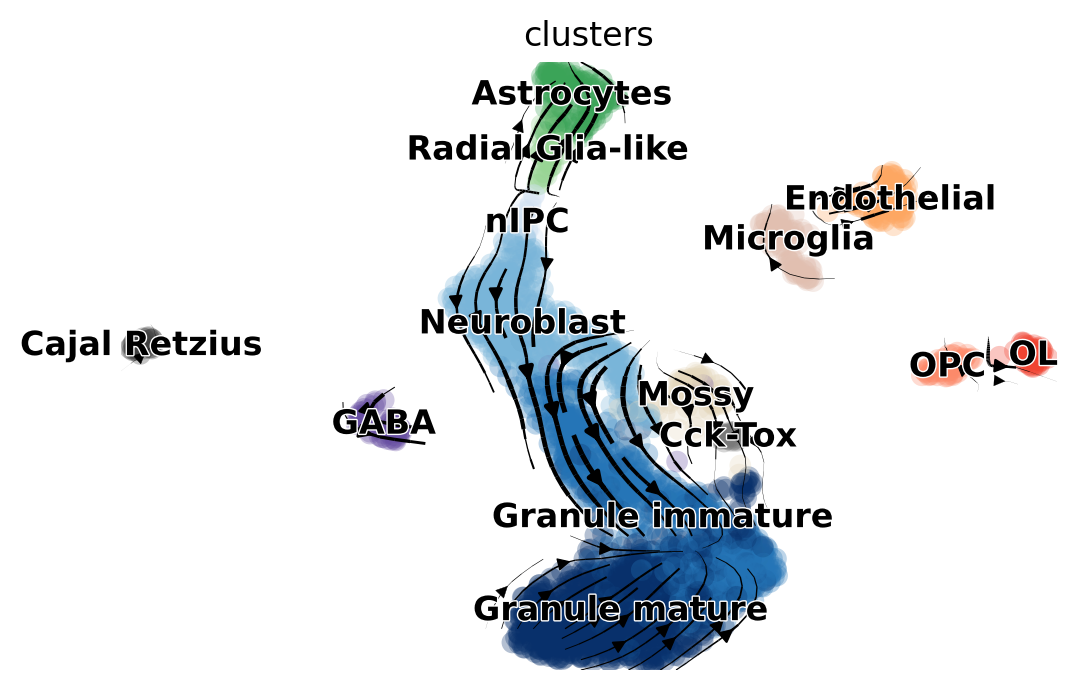

In [3]:
scv.tl.velocity(adata)
scv.tl.velocity_graph(adata)
scv.pl.velocity_embedding_stream(adata, basis='umap')

### Differential Kinetic Test

異なる細胞種や系統は異なる遺伝子ネットワークによって支配され得るので、異なるキネティクスレジームを示すことがあります。細胞種や系統が関連していても、alternative splicing、alternative polyadenylation、分解における調節により、キネティクスが異なる場合があります。

力学モデルによって、全体的なキネティクスを表す単一のモデルでは十分に説明できないような動態を示すクラスターを検出するために、キネティクスの差異に関する尤度比検定でこの問題に対処することができる。各細胞種は独立したフィットが有意に改善された尤度をもたらすかどうかについてテストされる。

尤度比は漸近的カイ二乗分布に従い、有意性を検定することができる。効率上の理由から、デフォルトでは、クラスタが全体的な力学によって十分に説明されているか、または異なる力学を示すかをテストするために、完全な位相軌跡の代わりに直交回帰が使用されていることに注意。

In [4]:
var_names = ['Tmsb10', 'Fam155a', 'Hn1', 'Rpl6']
scv.tl.differential_kinetic_test(adata, var_names=var_names, groupby='clusters')

recovering dynamics (using 1/40 cores)
    finished (0:00:02) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)

outputs model fit of gene: Rpl6
testing for differential kinetics
    finished (0:00:00) --> added 
    'fit_diff_kinetics', clusters displaying differential kinetics (adata.var)
    'fit_pvals_kinetics', p-values of differential kinetics (adata.var)

outputs model fit of gene: Rpl6


In [5]:
scv.get_df(adata[:, var_names], ['fit_diff_kinetics', 'fit_pval_kinetics'], precision=2)

,fit_diff_kinetics,fit_pval_kinetics
index,,
Tmsb10,Endothelial,6.02e-16
Fam155a,Cajal Retzius,8.35e-161
Hn1,Microglia,3.02e-03
Rpl6,Microglia,5.69e-16


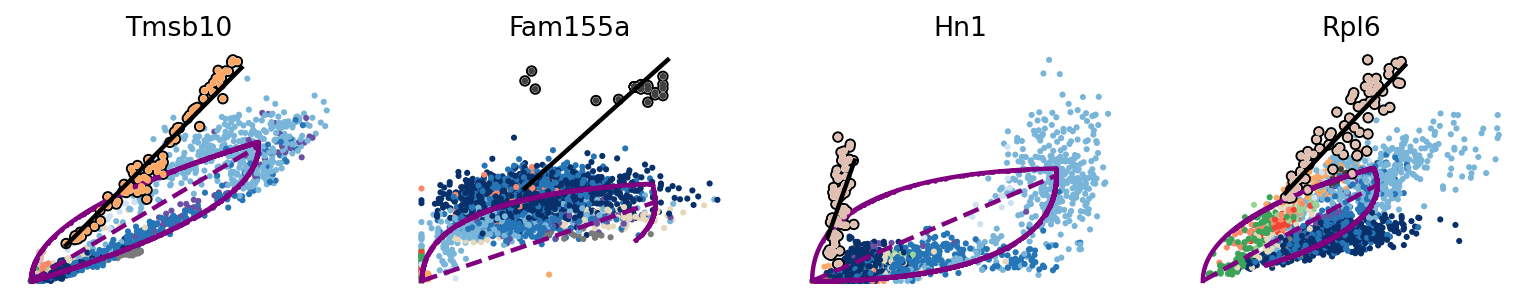

In [6]:
kwargs = dict(linewidth=2, add_linfit=True, frameon=False)
scv.pl.scatter(adata, basis=var_names, add_outline='fit_diff_kinetics', **kwargs)

例えばTmsb10では、内皮は全体的なダイナミクス（紫色の曲線）ではうまく説明できないような動力学的挙動を示す（縁取られた◯、黒線がフィットされた線）。

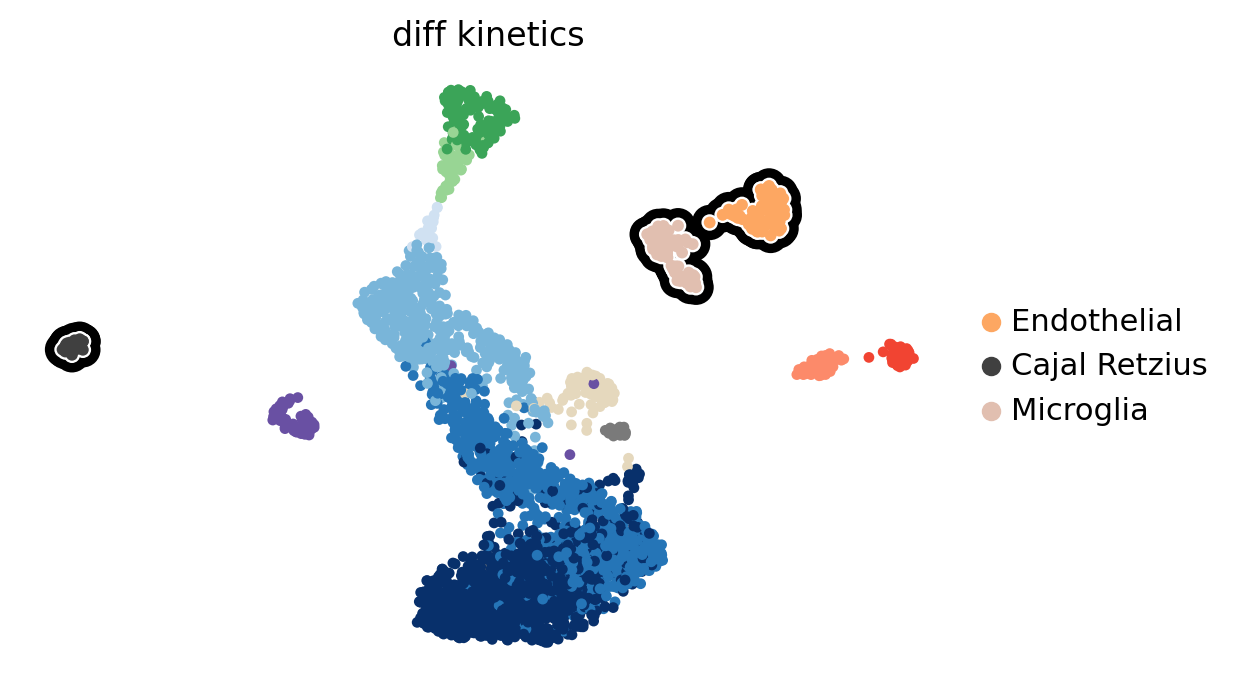

In [7]:
diff_clusters=list(adata[:, var_names].var['fit_diff_kinetics'])
scv.pl.scatter(adata, legend_loc='right', size=60, title='diff kinetics',
               add_outline=diff_clusters, outline_width=(.8, .2))

### Testing top-likelihood genes
尤度の高い遺伝子をスクリーニングすると、複数のキネティックレジームを示す遺伝子単位のダイナミクスがいくつか見つかります。

In [8]:
scv.tl.recover_dynamics(adata)
top_genes = adata.var['fit_likelihood'].sort_values(ascending=False).index[:100]
scv.tl.differential_kinetic_test(adata, var_names=top_genes, groupby='clusters')

recovering dynamics (using 1/40 cores)


  0%|          | 0/519 [00:00<?, ?gene/s]

    finished (0:03:33) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
testing for differential kinetics
    finished (0:00:20) --> added 
    'fit_diff_kinetics', clusters displaying differential kinetics (adata.var)
    'fit_pvals_kinetics', p-values of differential kinetics (adata.var)


特に、Cck/Tox、GABA、内皮、ミクログリアなど、主顆粒とは異なる細胞タイプが頻繁に出現する。

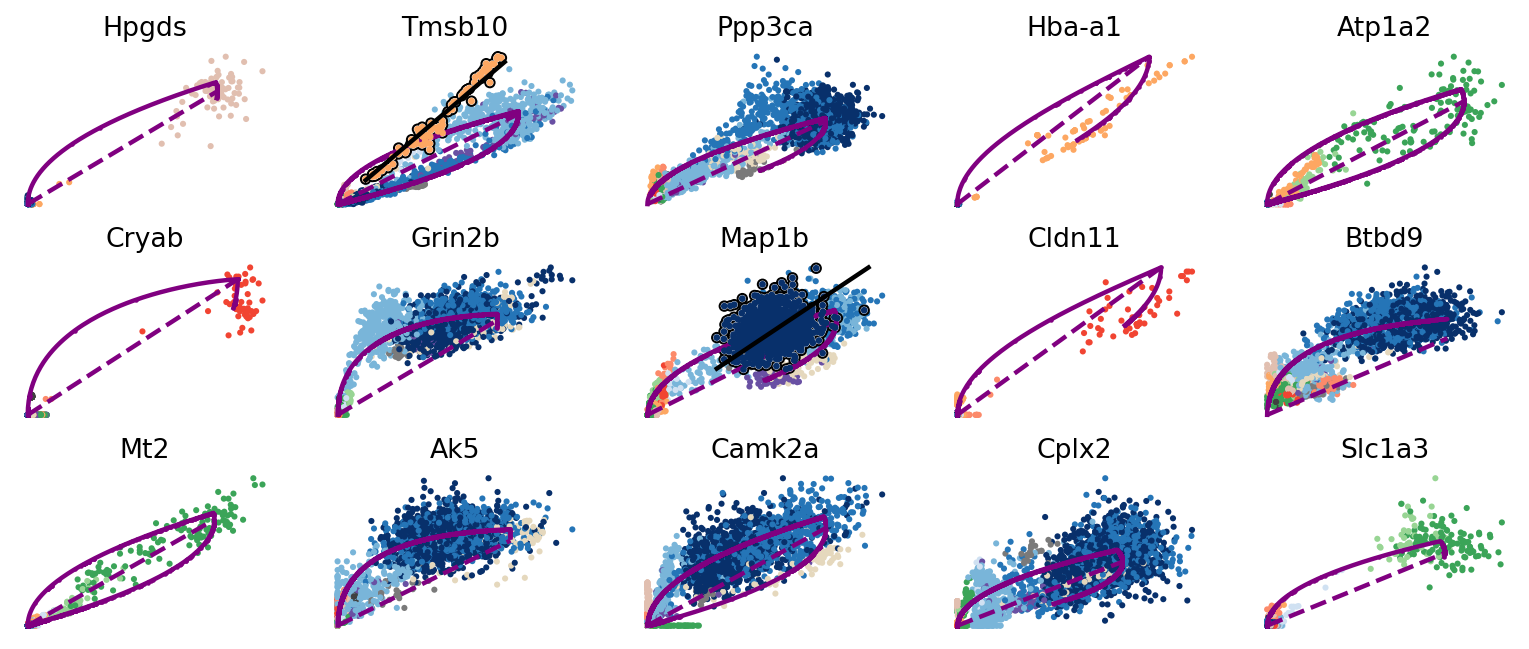

In [13]:
scv.pl.scatter(adata, basis=top_genes[:15], ncols=5, add_outline='fit_diff_kinetics', **kwargs)

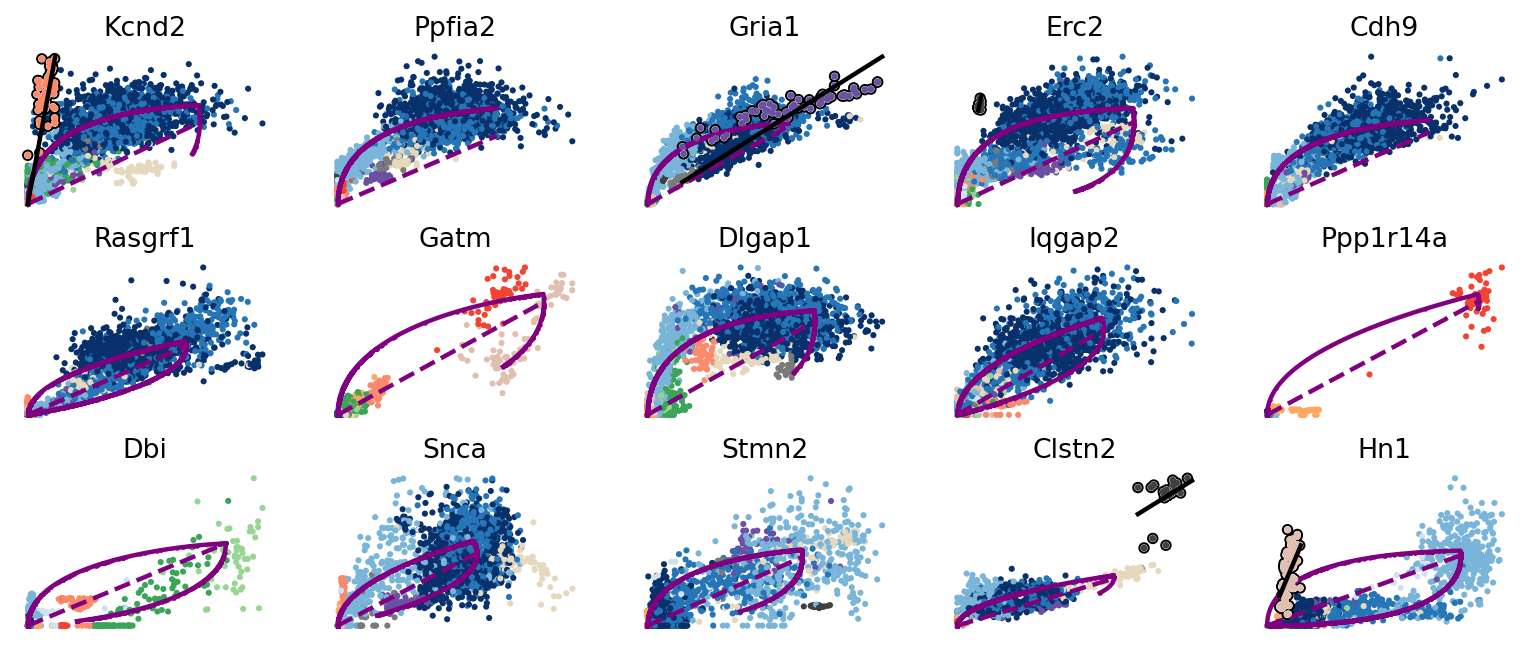

In [10]:
scv.pl.scatter(adata, basis=top_genes[15:30], ncols=5, add_outline='fit_diff_kinetics', **kwargs)

### Recompute velocities
最終的に、複数の競合するキネティクスレジームの情報を利用して速度を再計算することができます。

computing velocities
    finished (0:00:02) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/40 cores)


  0%|          | 0/2930 [00:00<?, ?cells/s]

    finished (0:00:05) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


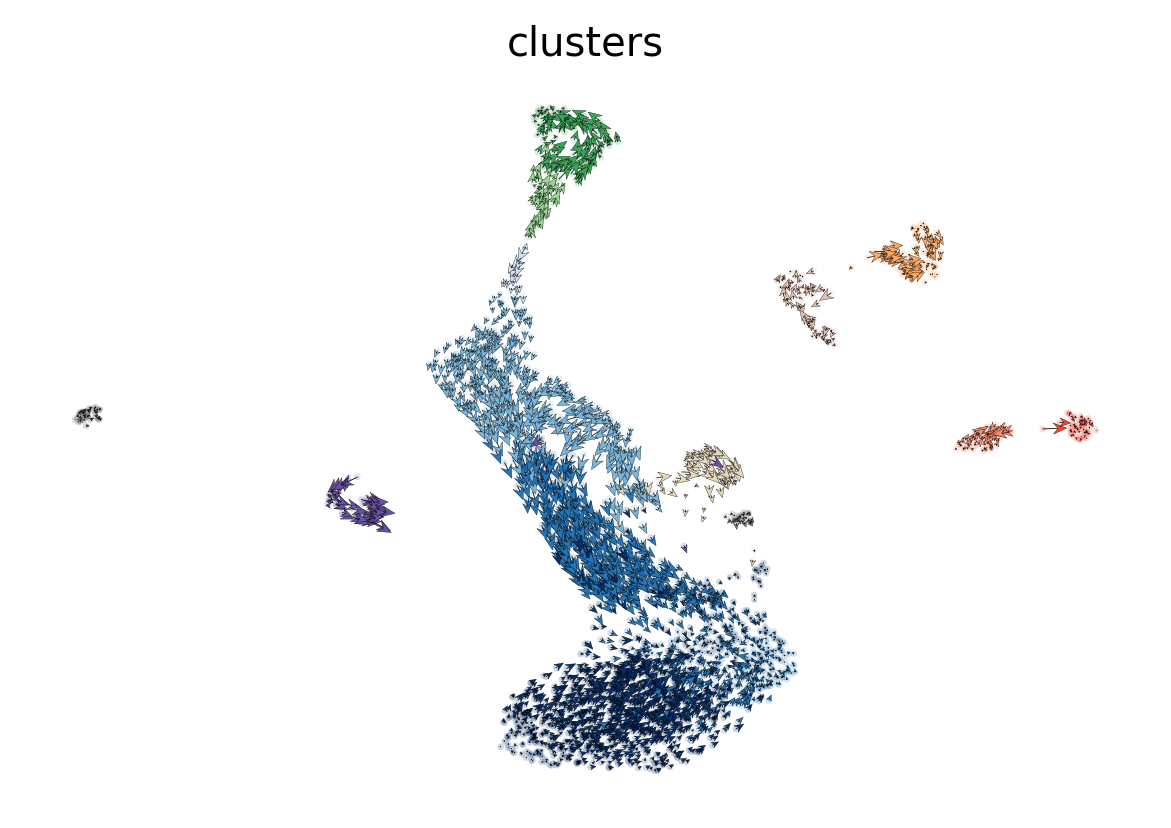

In [11]:
scv.tl.velocity(adata, diff_kinetics=True)
scv.tl.velocity_graph(adata)
scv.pl.velocity_embedding(adata, dpi=120, arrow_size=2, arrow_length=2)

In [12]:
import session_info
session_info.show()